## Bayesian optimization to infer Fractional Maxwell Liquid fitting parameters for the stress relaxation of shaving foam 

First, we are importing a variety of essential libraries that will help us with numerical computations, data manipulation, plotting, machine learning, Bayesian optimization, and other specialized tasks.

### Libraries:
- **NumPy (`numpy`)**: A fundamental package for numerical operations in Python.
- **Pandas (`pandas`)**: A powerful data manipulation and analysis library.
- **Matplotlib (`matplotlib.pyplot`)**: A plotting library used for creating static, animated, and interactive visualizations.
- **SciPy Special Functions (`scipy.special`)**: Specifically importing the gamma function for mathematical computations.
- **PyTorch (`torch`)**: A deep learning library for tensor computations and building neural networks.
- **BoTorch and GPyTorch**: Libraries for Gaussian Process Regression:
  - `SingleTaskGP`: For constructing Gaussian Process models.
  - `Standardize`: For standardizing outcomes.
  - `ExactMarginalLogLikelihood`: For exact marginal log likelihood calculation.
  - `fit_gpytorch_mll`: For fitting GP models.
- **Sobol Sequence (`sobol_seq`)**: For generating Sobol sequences for quasi-random sampling.
- **BoTorch Acquisition and Optimization**:
  - `qExpectedImprovement`: For Monte Carlo-based expected improvement.
  - `optimize_acqf`: For optimizing the acquisition function.
- **Scikit-Learn Preprocessing (`sklearn.preprocessing`)**: A collection of scalers for feature scaling, including:
  - `MinMaxScaler`
  - `RobustScaler`
  - `StandardScaler`
  - `MaxAbsScaler`
- **pyRheo (`pyRheo.relaxation_evaluator`)**: A custom library for evaluating relaxation properties.
- **SciencePlots (`scienceplots`)**: A library to enhance Matplotlib plots with scientific visual styles.

These imports will provide all the necessary tools for the subsequent analysis and model building steps in this notebook.


In [19]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
import sobol_seq
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.logei import qLogExpectedImprovement
from botorch.optim.optimize import optimize_acqf
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler
from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel
from pyRheo.relaxation_evaluator import RelaxationEvaluator
import scienceplots
plt.style.use(['science', 'nature', 'retro'])

## Random Error Generation, Objective Function, Sobol Sampling and Model Initialization

In this section, we define various key functions and setup procedures required for our model analysis and optimization:



In [20]:
# Error function to add to the fractional rheology model
def createRandomError(n, std):
    return np.random.normal(loc=1, scale=std, size=n)

# Objective function to minimize (RRS weighted by true values)
def objective(params):
    logG, logeta, beta = params
    G = 10 ** logG
    eta = 10 ** logeta
    params_no_scale = G, eta, beta
    model = "FractionalMaxwellLiquid"
    evaluator = RelaxationEvaluator(model=model)
    # Compute relaxation
    model_values = evaluator.compute_model(params_no_scale, time, mittag_leffler_type="Pade72") 
    # Add noise
    error = createRandomError(time.shape[0], 0.02)
    model_values_noisy = np.multiply(model_values, error)
    # Define objective functions
    obj1 = np.sum(((y_true - model_values_noisy) / y_true) ** 2)
    return -np.log10(obj1) # we take the negative because the EI by default maximizes and we are looking to minimize
    
# Function to create Sobol samples
def sobol_sample(space, n_samples, seed=None):
    if seed is not None:
        np.random.seed(seed)
    sobol_samples = sobol_seq.i4_sobol_generate(len(space), n_samples)
    sobol_scaled = sobol_samples * (space[:, 1] - space[:, 0]) + space[:, 0]
    return np.array(sobol_scaled)

# Initialize model function for single-objective problem
def initialize_model(train_x, train_obj):
    train_obj = train_obj.unsqueeze(-1)  # Add dimension for single task GP
    model = SingleTaskGP(train_x, train_obj, covar_module=MaternKernel(nu=1.5),)
                        #outcome_transform=Standardize(m=1))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

# Compute the qEI acquisition function to find new candidate points that maximize the objective
def compute_qei_acquisition_function(model, train_x, bounds):
    acq_func = qLogExpectedImprovement(
        model=model,
        best_f=train_x.max(),
    )
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,  # Number of candidates to generate in a batch
        num_restarts=3,
        raw_samples=50,
        options={"batch_limit": 5, "maxiter": 50},
    )
    return candidates

## Loading Rheological Data and Defining Search Space

In this section, we load the rheological data from a CSV file and define the search space bounds for our parameter optimization.

In [21]:
# Load rheological data
data = pd.read_csv('./data/shaving_foam/stressrelaxation_liquidfoam_data.csv', delimiter='\t', decimal=".")
time = data['Time'].values
y_true = data['Relaxation Modulus'].values

# Define search space bounds
param_space = np.array([
    [1, 3],  # log10 scale for G
    [4, 6],  # log10 scale for V
    [0.001, 0.5]   # real scale for beta
])

## Exploration Phase: Initial Sampling, Scaling, and Model Initialization

In this section, we conduct the initial exploration phase of our optimization process.


In [22]:
# Set random seed
seed = 42

# Initial sampling using Sobol sequence
n_initial_points = 32
X_samples = sobol_sample(param_space, n_initial_points, seed=seed)
y_samples = np.array([objective(x) for x in X_samples])

# Apply MaxAbs scaling to the target values
scaler = StandardScaler()
y_samples_scaled = scaler.fit_transform(y_samples.reshape(-1, 1)).flatten()

# Convert to tensors for BoTorch
X_samples_tensor = torch.tensor(X_samples, dtype=torch.double)
y_samples_tensor = torch.tensor(y_samples_scaled, dtype=torch.double)

# Compute bounds for optimization
bounds = torch.stack([
    torch.tensor(param_space[:, 0], dtype=torch.double),
    torch.tensor(param_space[:, 1], dtype=torch.double)
])

# Initialize and fit the GP model
mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
fit_gpytorch_mll(mll)

/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0160], dtype=torch.float64), mean = tensor([7.5634e-16], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
  )
)

## Exploitation Phase: Iterative Sampling and Model Updating

In this section, we perform the exploitation phase of our optimization process. We iteratively generate new samples using the q-Expected Improvement (qEI) acquisition function, evaluate the objective function at these new sample points, and update our model accordingly.

### Iterative Exploitation Process

For each iteration in the exploitation phase:
1. **Generate New Candidates**: We compute new candidate points using the qEI acquisition function.
2. **Evaluate Objective**: The objective function is evaluated at the new candidate points.
3. **Apply Scaling**: The new objective values are scaled using the previously defined MaxAbsScaler.
4. **Update Samples and Objectives**: The new sample and corresponding objective values (both original and scaled) are appended to the existing lists of samples and objective values. We also save the index of the new sample for tracking purposes.
5. **Update Tensors**: The updated samples and objective values are converted to tensors.
6. **Model Update**: The GP model is re-initialized and fitted using the updated data.
7. **Logging**: The iteration details, including the new sample and objective value, are printed.


In [23]:
import time as timer

# Exploitation phase using qEI
n_exploitation_iter = 200 # Number of iterations
new_indices = []  # To keep track of new points added during exploitation
objective_values = list(y_samples)  # Track original (not scaled) objective values

# Initialize timing variables
times_per_iteration = []
cumulative_time = 0

# Stop condition parameters
no_improvement_limit = 100  # Stop if no improvement after 50 iterations
no_improvement_counter = 0
best_objective_value = float('inf')  # Assuming we're minimizing
tolerance = 1e-3  # Minimum improvement required to reset the counter

for i in range(n_exploitation_iter):
    new_candidates = compute_qei_acquisition_function(model, y_samples_tensor, bounds)
    new_sample = new_candidates.detach().cpu().numpy().reshape(-1)
    new_sample_y = objective(new_sample)
    
    # Apply scaling to the new y value
    new_sample_y_scaled = scaler.transform(np.array([new_sample_y]).reshape(-1, 1)).flatten()[0]
    
    # Append the new sample to the samples and objective values (both original and scaled)
    new_indices.append(len(y_samples))  # Save the index of the new sample
    X_samples = np.vstack([X_samples, new_sample])
    y_samples = np.append(y_samples, new_sample_y)  # Original scale objective values
    y_samples_scaled = np.append(y_samples_scaled, new_sample_y_scaled)  # Scaled objective values
    
    # Update tensors
    X_samples_tensor = torch.tensor(X_samples, dtype=torch.double)
    y_samples_tensor = torch.tensor(y_samples_scaled, dtype=torch.double)

    # Append the objective value to the list (original scale)
    objective_values.append(new_sample_y)
    
    # Update the model with the new data
    mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
    start_time = timer.time()

    fit_gpytorch_mll(mll)
    
    # Record iteration time
    iteration_time = timer.time() - start_time
    times_per_iteration.append(iteration_time)
    cumulative_time += iteration_time
    
    print(f"Exploitation {i + 1}/{n_exploitation_iter} - New sample: {new_sample}, Objective value: {new_sample_y}")
    
    # Check stop condition based on no improvement with tolerance
    improvement = best_objective_value - new_sample_y
    if improvement > tolerance:
        best_objective_value = new_sample_y
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1

    if no_improvement_counter >= no_improvement_limit:
        print(f"Stopping early due to no significant improvement (>{tolerance}) in the last {no_improvement_limit} iterations.")
        break

/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.9856], dtype=torch.float64), mean = tensor([0.0002], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-

Exploitation 1/200 - New sample: [1.  4.  0.5], Objective value: -3.218784461379242
Exploitation 2/200 - New sample: [2.24859552 4.84729157 0.5       ], Objective value: -3.0534878449749647
Exploitation 3/200 - New sample: [2.5043338  5.49713232 0.5       ], Objective value: -2.8757299832454777


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.9624], dtype=torch.float64), mean = tensor([0.0241], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.9730], dtype=torch.float

Exploitation 4/200 - New sample: [1.e+00 6.e+00 1.e-03], Objective value: -2.96504790642878
Exploitation 5/200 - New sample: [3.         5.04747193 0.5       ], Objective value: -2.4653150073062555
Exploitation 6/200 - New sample: [2.13438867 5.51694285 0.5       ], Objective value: -3.086836210505186


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.9670], dtype=torch.float64), mean = tensor([0.0918], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.9765], dtype=torch.float

Exploitation 7/200 - New sample: [2.86816057 5.0858384  0.5       ], Objective value: -2.4910944449493084
Exploitation 8/200 - New sample: [2.21347324 4.57141551 0.23868265], Objective value: -2.4348253777191835


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0206], dtype=torch.float64), mean = tensor([0.1766], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0497], dtype=torch.float

Exploitation 9/200 - New sample: [2.07645672 4.54369789 0.11249901], Objective value: -1.9928731256350503
Exploitation 10/200 - New sample: [2.03066448 4.51784156 0.01754816], Objective value: -2.0913666735143286


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0669], dtype=torch.float64), mean = tensor([0.2599], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0544], dtype=torch.float

Exploitation 11/200 - New sample: [2.00300595 4.54815581 0.11425872], Objective value: -2.197853172707081
Exploitation 12/200 - New sample: [1.61360893e+00 4.00000000e+00 1.00000000e-03], Objective value: -2.97765239163056


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0756], dtype=torch.float64), mean = tensor([0.3007], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0882], dtype=torch.float

Exploitation 13/200 - New sample: [2.12963689 4.52572761 0.04531834], Objective value: -2.108058172860091
Exploitation 14/200 - New sample: [2.07854766 4.4678789  0.08744146], Objective value: -2.1977760803731123


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1795], dtype=torch.float64), mean = tensor([0.4051], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2263], dtype=torch.float

Exploitation 15/200 - New sample: [2.08027572 4.59607266 0.05754361], Objective value: -1.298648412041617
Exploitation 16/200 - New sample: [2.07945456 4.61720638 0.02787943], Objective value: -1.6141781344504664


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2387], dtype=torch.float64), mean = tensor([0.4950], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2347], dtype=torch.float

Exploitation 17/200 - New sample: [1.97115638e+00 4.68210219e+00 1.00000000e-03], Objective value: -2.0274754271043904
Exploitation 18/200 - New sample: [2.14903540e+00 4.64483514e+00 1.00000000e-03], Objective value: -2.364929054712776


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2987], dtype=torch.float64), mean = tensor([0.5772], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3289], dtype=torch.float

Exploitation 19/200 - New sample: [2.05745635 4.60859831 0.04890796], Objective value: -1.2945979928610671
Exploitation 20/200 - New sample: [2.05715966 4.63466069 0.07835024], Objective value: -1.6269444254538505


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3221], dtype=torch.float64), mean = tensor([0.6410], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3671], dtype=torch.float

Exploitation 21/200 - New sample: [2.04213949 4.69059643 0.15901282], Objective value: -2.358871600426156
Exploitation 22/200 - New sample: [2.04053312 4.60477291 0.04105192], Objective value: -1.3574181727633454
Exploitation 23/200 - New sample: [2.36666316 4.51210874 0.14764986], Objective value: -2.192159823995111


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3637], dtype=torch.float64), mean = tensor([0.7159], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4028], dtype=torch.float

Exploitation 24/200 - New sample: [2.05563634 4.59560164 0.05261138], Objective value: -1.352950800238821
Exploitation 25/200 - New sample: [2.06159004 4.59511356 0.05540195], Objective value: -1.3429157938738583
Exploitation 26/200 - New sample: [2.06589594 4.59923441 0.05853855], Objective value: -1.3176902280816085


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4721], dtype=torch.float64), mean = tensor([0.8632], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5236], dtype=torch.float

Exploitation 27/200 - New sample: [2.34701777 4.66737445 0.14445843], Objective value: -1.0045307405747168
Exploitation 28/200 - New sample: [2.32349282 4.66234394 0.13849923], Objective value: -0.8190455137035613


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6194], dtype=torch.float64), mean = tensor([1.0323], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6817], dtype=torch.float

Exploitation 29/200 - New sample: [2.308722   4.66012033 0.12469538], Objective value: -1.0776404403435538
Exploitation 30/200 - New sample: [2.31990807 4.65885106 0.15633974], Objective value: -0.6352037886657602


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7058], dtype=torch.float64), mean = tensor([1.1405], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 31/200 - New sample: [2.29800866 4.67316795 0.16067743], Objective value: -1.1540235130621141
Exploitation 32/200 - New sample: [2.06656182 4.60528666 0.05118687], Objective value: -1.2721576385241038


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7221], dtype=torch.float64), mean = tensor([1.1805], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7641], dtype=torch.float

Exploitation 33/200 - New sample: [2.32453604 4.64312082 0.15931717], Objective value: -0.7555260078270778
Exploitation 34/200 - New sample: [2.32517459 4.65889663 0.159666  ], Objective value: -0.6911898557708792


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8060], dtype=torch.float64), mean = tensor([1.2896], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8148], dtype=torch.float

Exploitation 35/200 - New sample: [2.33026625 4.65296556 0.18270079], Objective value: -1.309427145339073


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8618], dtype=torch.float64), mean = tensor([1.3816], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8767], dtype=torch.float

Exploitation 36/200 - New sample: [2.3222639  4.65488205 0.15195976], Objective value: -0.5073955242126048
Exploitation 37/200 - New sample: [2.32302623 4.62704959 0.13985587], Objective value: -1.0703366676994661


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9186], dtype=torch.float64), mean = tensor([1.4757], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 38/200 - New sample: [2.32254137 4.65422882 0.15062547], Objective value: -0.4839125773217006


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9563], dtype=torch.float64), mean = tensor([1.5286], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 39/200 - New sample: [2.32222489 4.6515338  0.14882078], Objective value: -0.4980110004035823


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9527], dtype=torch.float64), mean = tensor([1.5521], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 40/200 - New sample: [2.37703127 4.62950784 0.14566648], Objective value: -1.5118652002356214


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9551], dtype=torch.float64), mean = tensor([1.5813], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 41/200 - New sample: [2.06989829 4.60483953 0.05188717], Objective value: -1.2759423667878163


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9893], dtype=torch.float64), mean = tensor([1.6316], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 42/200 - New sample: [2.31911394 4.65235392 0.14949859], Objective value: -0.46088209555052984


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9900], dtype=torch.float64), mean = tensor([1.6590], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 43/200 - New sample: [2.06822136 4.60590946 0.05108808], Objective value: -1.2750542472516981


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0203], dtype=torch.float64), mean = tensor([1.7069], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 44/200 - New sample: [2.31537849 4.65085098 0.14880286], Objective value: -0.46283085665088125


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0480], dtype=torch.float64), mean = tensor([1.7534], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 45/200 - New sample: [2.31711349 4.65188163 0.14904706], Objective value: -0.4691044646710232


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0732], dtype=torch.float64), mean = tensor([1.7984], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 46/200 - New sample: [2.31702135 4.65055127 0.15021403], Objective value: -0.4791746449597968


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0707], dtype=torch.float64), mean = tensor([1.8223], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 47/200 - New sample: [2.06704407 4.605235   0.05100373], Objective value: -1.2784748752380415


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0941], dtype=torch.float64), mean = tensor([1.8658], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 48/200 - New sample: [2.31545893 4.65122034 0.1466494 ], Objective value: -0.46039757666145525


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1159], dtype=torch.float64), mean = tensor([1.9084], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 49/200 - New sample: [2.31458765 4.65319406 0.14764595], Objective value: -0.45539432693019855


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1370], dtype=torch.float64), mean = tensor([1.9504], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1325], dtype=torch.float

Exploitation 50/200 - New sample: [2.3109068  4.6511728  0.14708483], Objective value: -0.4341180086378802
Exploitation 51/200 - New sample: [2.06731164 4.60631044 0.05218476], Objective value: -1.270365700480741


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1510], dtype=torch.float64), mean = tensor([2.0114], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1607], dtype=torch.float

Exploitation 52/200 - New sample: [2.30596268 4.64914909 0.14675724], Objective value: -0.4495709551822806
Exploitation 53/200 - New sample: [2.28962609 4.64118759 0.14682979], Objective value: -0.6741861266911282


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1774], dtype=torch.float64), mean = tensor([2.0837], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 54/200 - New sample: [2.3092617  4.65119622 0.14672033], Objective value: -0.4326734078559938


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1941], dtype=torch.float64), mean = tensor([2.1220], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 55/200 - New sample: [2.30925763 4.6507314  0.14448515], Objective value: -0.40162235090047016


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1880], dtype=torch.float64), mean = tensor([2.1401], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2021], dtype=torch.float

Exploitation 56/200 - New sample: [2.06760063 4.60773785 0.05332096], Objective value: -1.2641462321858399
Exploitation 57/200 - New sample: [2.30824448 4.64948576 0.14244065], Objective value: -0.4338431958308132


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2096], dtype=torch.float64), mean = tensor([2.2074], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 58/200 - New sample: [2.25302867 4.63278791 0.13028383], Objective value: -0.6208095137566245


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2062], dtype=torch.float64), mean = tensor([2.2282], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 59/200 - New sample: [2.2552768  4.60903639 0.13004679], Objective value: -1.0685027136603402


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2006], dtype=torch.float64), mean = tensor([2.2459], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 60/200 - New sample: [2.24031345 4.64707333 0.14305785], Objective value: -1.1927626279831647


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1939], dtype=torch.float64), mean = tensor([2.2617], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 61/200 - New sample: [2.06778174 4.60928834 0.0543645 ], Objective value: -1.2603034497549475


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2058], dtype=torch.float64), mean = tensor([2.2950], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 62/200 - New sample: [2.30735985 4.65292727 0.1438594 ], Objective value: -0.41774682808062874


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2148], dtype=torch.float64), mean = tensor([2.3260], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 63/200 - New sample: [2.26882901 4.63913374 0.1230632 ], Objective value: -0.4915475893678204


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2078], dtype=torch.float64), mean = tensor([2.3407], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 64/200 - New sample: [2.06821862 4.60978662 0.05502555], Objective value: -1.2505388993327076


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2010], dtype=torch.float64), mean = tensor([2.3553], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 65/200 - New sample: [2.07111888 4.61107311 0.05728074], Objective value: -1.2396535204973471


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2102], dtype=torch.float64), mean = tensor([2.3857], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 66/200 - New sample: [2.26976331 4.63761407 0.13261764], Objective value: -0.44415447211134473


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2199], dtype=torch.float64), mean = tensor([2.4163], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 67/200 - New sample: [2.27880422 4.64037341 0.13017236], Objective value: -0.40356968092650986


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2315], dtype=torch.float64), mean = tensor([2.4482], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 68/200 - New sample: [2.27641762 4.64450273 0.13131253], Objective value: -0.3114171582218584


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2424], dtype=torch.float64), mean = tensor([2.4794], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 69/200 - New sample: [2.27553152 4.64883768 0.13201095], Objective value: -0.30946752650335424


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2517], dtype=torch.float64), mean = tensor([2.5094], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2613], dtype=torch.float

Exploitation 70/200 - New sample: [2.27420697 4.64797242 0.12806801], Objective value: -0.34142885850909754
Exploitation 71/200 - New sample: [2.27601302 4.64677761 0.13252713], Objective value: -0.30827157178382714


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2708], dtype=torch.float64), mean = tensor([2.5693], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 72/200 - New sample: [2.27812966 4.64784656 0.13206991], Objective value: -0.2884771902176964
Exploitation 73/200 - New sample: [2.28079296 4.64962342 0.13276303], Objective value: -0.31376050275857664


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2790], dtype=torch.float64), mean = tensor([2.5981], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2868], dtype=torch.float

Exploitation 74/200 - New sample: [2.27847506 4.64767783 0.13092426], Objective value: -0.30984226941504056
Exploitation 75/200 - New sample: [2.30866616 4.65137611 0.14431241], Objective value: -0.41190001152813777


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2980], dtype=torch.float64), mean = tensor([2.6792], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 76/200 - New sample: [2.27835567 4.64789571 0.13447733], Objective value: -0.33598906829672237


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2943], dtype=torch.float64), mean = tensor([2.6962], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 77/200 - New sample: [2.33488792 4.66706703 0.1441156 ], Objective value: -0.8469416304209108


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2991], dtype=torch.float64), mean = tensor([2.7215], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 78/200 - New sample: [2.27859658 4.65297528 0.13100211], Objective value: -0.3713196424806857


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.3040], dtype=torch.float64), mean = tensor([2.7467], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 79/200 - New sample: [2.26882655 4.6472125  0.13202368], Objective value: -0.35137891511109864


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2955], dtype=torch.float64), mean = tensor([2.7557], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 80/200 - New sample: [2.07322077 4.61137043 0.0585297 ], Objective value: -1.2424621330775463


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2999], dtype=torch.float64), mean = tensor([2.7801], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 81/200 - New sample: [2.28653407 4.64763806 0.13219659], Objective value: -0.3563349107646511


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.3038], dtype=torch.float64), mean = tensor([2.8039], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 82/200 - New sample: [2.28904805 4.6531195  0.13725974], Objective value: -0.3637505815626301


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2954], dtype=torch.float64), mean = tensor([2.8123], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 83/200 - New sample: [2.07178431 4.61141798 0.05777947], Objective value: -1.23823929237937


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2998], dtype=torch.float64), mean = tensor([2.8362], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2916], dtype=torch.float

Exploitation 84/200 - New sample: [2.27683599 4.64691087 0.13090103], Objective value: -0.3183638670985796
Exploitation 85/200 - New sample: [2.07176532 4.61162404 0.05779824], Objective value: -1.2313383194933107
Exploitation 86/200 - New sample: [2.23204155 4.63431662 0.09282393], Objective value: -1.1828187753612212


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2837], dtype=torch.float64), mean = tensor([2.8529], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2879], dtype=torch.float

Exploitation 87/200 - New sample: [2.28011805 4.64692693 0.13183777], Objective value: -0.31057756061318265


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2876], dtype=torch.float64), mean = tensor([2.8948], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 88/200 - New sample: [2.25748232 4.65441802 0.119122  ], Objective value: -0.5446789523338614


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2916], dtype=torch.float64), mean = tensor([2.9175], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2934], dtype=torch.float

Exploitation 89/200 - New sample: [2.27797284 4.64749777 0.13190703], Objective value: -0.29311239981226067
Exploitation 90/200 - New sample: [2.30823269 4.65143619 0.14425729], Objective value: -0.3984964530485466


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2965], dtype=torch.float64), mean = tensor([2.9596], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 91/200 - New sample: [2.28370307 4.64917715 0.1358167 ], Objective value: -0.31370149284033655


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2883], dtype=torch.float64), mean = tensor([2.9661], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2912], dtype=torch.float

Exploitation 92/200 - New sample: [2.07151155 4.61259429 0.05778328], Objective value: -1.2389399909760972
Exploitation 93/200 - New sample: [2.27801795 4.6474084  0.13200961], Objective value: -0.30896084457181705


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2912], dtype=torch.float64), mean = tensor([3.0054], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 94/200 - New sample: [2.28141552 4.65371539 0.1391386 ], Objective value: -0.471987417223873


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2830], dtype=torch.float64), mean = tensor([3.0113], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 95/200 - New sample: [2.0716127  4.61198272 0.05789927], Objective value: -1.2405264369449172


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2835], dtype=torch.float64), mean = tensor([3.0297], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2755], dtype=torch.float

Exploitation 96/200 - New sample: [2.30908586 4.65073311 0.14388196], Objective value: -0.4278742355031515
Exploitation 97/200 - New sample: [2.07177819 4.61178199 0.057742  ], Objective value: -1.241061405671779


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2676], dtype=torch.float64), mean = tensor([3.0410], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 98/200 - New sample: [2.07186441 4.61174882 0.05762182], Objective value: -1.234787980669971


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2699], dtype=torch.float64), mean = tensor([3.0605], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 99/200 - New sample: [2.27359113 4.64589351 0.13157194], Objective value: -0.31011710943949794


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2722], dtype=torch.float64), mean = tensor([3.0800], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 100/200 - New sample: [2.27803984 4.64748094 0.13198622], Objective value: -0.29692814038536325
Exploitation 101/200 - New sample: [2.27808369 4.64748429 0.13200845], Objective value: -0.284282951293376
Stopping early due to no significant improvement (>0.001) in the last 100 iterations.


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2746], dtype=torch.float64), mean = tensor([3.0993], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


## Visualizing Optimization Progress

In this section, we plot the negative of the objective function values as a function of the number of iterations. This helps us visually assess the optimization progress and the performance of the Sobol and Expected Improvement (EI) sampling strategies.

### Steps Involved in the Plotting Process:

1. **Configure the Plot**:
   We set the figure size and layout for constrained layout setting for better spacing.
   
2. **Prepare Data for Plotting**:
   - We create an array representing the iterations.
   - We negate the objective function values (`neg_objective_values`) because we are minimizing the objective, and lower values represent better performance.

3. **Plot the Sobol and EI Samples**:
   - Plot the initial Sobol samples in one color (`#89BFA9`), marking them as 'Sobol'.
   - Plot the subsequent EI samples in another color (`#60568A`), marking them as 'EI'.

4. **Customize Plot Appearance**:
   - Set the limits for the x-axis.
   - Label the x-axis as the number of iterations (`$n$`).
   - Label the y-axis as the log of the Residual Sum of Squares (RSS) weighted by true values (`$\\log$ RSS$_{w_{i}}$`).
   - Customize the font size of axis labels and tick labels.
   - Add a legend to distinguish between Sobol and EI samples.
  
5. **Display the Plot**:
   - Show the plot using `plt.show()`.
   
6. **Print the Minimum Objective Value**:
   - Print the minimum value of the negated objective values to see the best objective value achieved during the optimization process.


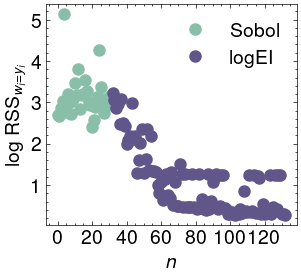

The minimum value of the objective function in log10 scale is 0.2843
Cumulative time for all iterations: 6.8488 seconds


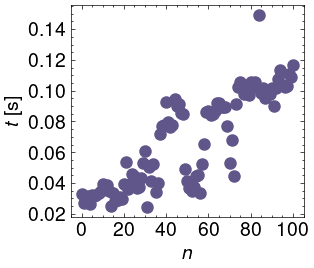

In [24]:
# Plotting the negative of the objective as a function of iterations

# Configure the Figure
plt.figure(figsize=(3, 2.75), constrained_layout=True)

# Prepare Data for Plotting
iterations = np.arange(len(objective_values))             # Array of iteration indices
neg_objective_values = -np.array(objective_values)        # Convert back to original scale by multiplying by -1

# Plot Initial Sobol Samples
plt.plot(
    iterations[:n_initial_points], 
    neg_objective_values[:n_initial_points], 
    'o', 
    markersize=8, 
    label='Sobol', 
    color='#89BFA9'
)

# Plot EI Samples
plt.plot(
    iterations[n_initial_points:], 
    neg_objective_values[n_initial_points:], 
    'o', 
    markersize=8, 
    label='logEI', 
    color='#60568A'
)

# Customize Plot Appearance
#plt.xlim(0, 21)                                          # Set x-axis limit
#plt.ylim(-1, 6)                                        # Uncomment and set y-axis limit if needed
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$\\log$ RSS$_{w_{i}=y_i}$', fontsize=14)           # Y-axis label
plt.xticks(fontsize=14)                                   # X-axis tick label size
plt.yticks(fontsize=14)                                   # Y-axis tick label size
plt.legend(fontsize=14, loc="best")                       # Display legend

# Display the Plot
plt.savefig("fig_ei_relaxation_liquidfoam.pdf")                    # Uncomment to save the plot
plt.show()

# Print the Minimum Objective Value
print(f"The minimum value of the objective function in log10 scale is {np.min(neg_objective_values):.4f}")

# Plotting the time per iteration
plt.figure(figsize=(3, 2.75))
plt.plot(times_per_iteration, 'o', markersize=8, color='#60568A')
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$t$ [s]', fontsize=14)           # Y-axis label
plt.xticks(fontsize=14)                                   # X-axis tick label size
plt.yticks(fontsize=14)                                   # Y-axis tick label size
#plt.legend(fontsize=14, loc="best")                       # Display legend

# Printing the cumulative time
print(f"Cumulative time for all iterations: {cumulative_time:.4f} seconds")

## Fitting and Visualizing the Model with Best Parameters from Bayesian Optimization

In this section, we:
1. Define the fractional model evaluator.
2. Extract and print the best parameters obtained from the Bayesian Optimization (BO) phase.
3. Fit the model using the best parameters and compute the model values.
4. Calculate the Residual Sum of Squares (RSS) for the fitted model.
5. Plot the original data, the fitted model from Bayesian Optimization, and the optimized model.


Best parameters from Bayesian Optimization: G = 189.71, eta = 44410.36, beta = 0.13
RSS_w for the Bayesian Optimization model: 1.33504


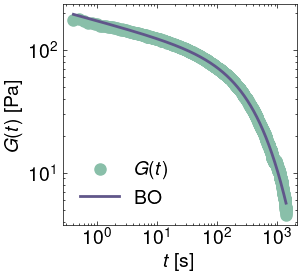

In [25]:
from cycler import cycler  # Import the cycler for customizing plot cycles

# Define model evaluator
fractional_model_name = "FractionalMaxwellLiquid"
evaluator = RelaxationEvaluator(model=fractional_model_name)

# Extract the best parameters from Bayesian Optimization phase
best_idx = np.argmax(y_samples)
best_params = X_samples[best_idx]
logG_best, logeta_best, beta_best = best_params
G_best_bo = 10 ** logG_best
eta_best_bo = 10 ** logeta_best

# Print the best parameters from Bayesian Optimization
print("Best parameters from Bayesian Optimization: G = {:.2f}, eta = {:.2f}, beta = {:.2f}".format(G_best_bo, eta_best_bo, beta_best))

# Fit the model with the best parameters from Bayesian Optimization
best_params_no_scale = G_best_bo, eta_best_bo, beta_best
bo_model_values = evaluator.compute_model(best_params_no_scale, time, mittag_leffler_type="Pade72")

# Compute the RSS for the Bayesian Optimization model
rss_bo = np.sum(((y_true - bo_model_values) / y_true) ** 2)
print(f"RSS_w for the Bayesian Optimization model: {rss_bo:.5f}")

# Get the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the data, the fitted model from Bayesian Optimization, and the final optimized model
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)
plt.plot(time, y_true, 'o', markersize=8, color='#89BFA9', label='$G(t)$')  # Original data
plt.plot(time, bo_model_values, '-', color='#60568A', lw=2, label='BO')   # BO model fit
#plt.plot(time, optimal_model_values, '-', color=colors[1], lw=2, label='L-BFGS-B')  # Uncomment to plot optimized model values

# Configure the plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t$ [s]', fontsize=14)
plt.ylabel(r'$G(t)$ [Pa]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="lower left")

# Display the plot
plt.savefig("fig_bo_fit_relaxation_data_liquidfoam.pdf")  # Uncomment to save the plot
plt.show()

## Visualizing Surrogate Model Predictions for Different parameter Values

In this section, we:
1. Define a function to predict model outputs on a 2D grid of parameters.
2. Evaluate the model on a grid for various fixed beta values.
3. Create contour plots for each beta value showing the predictions of the model.
4. Identify and display the global minima for each beta value.

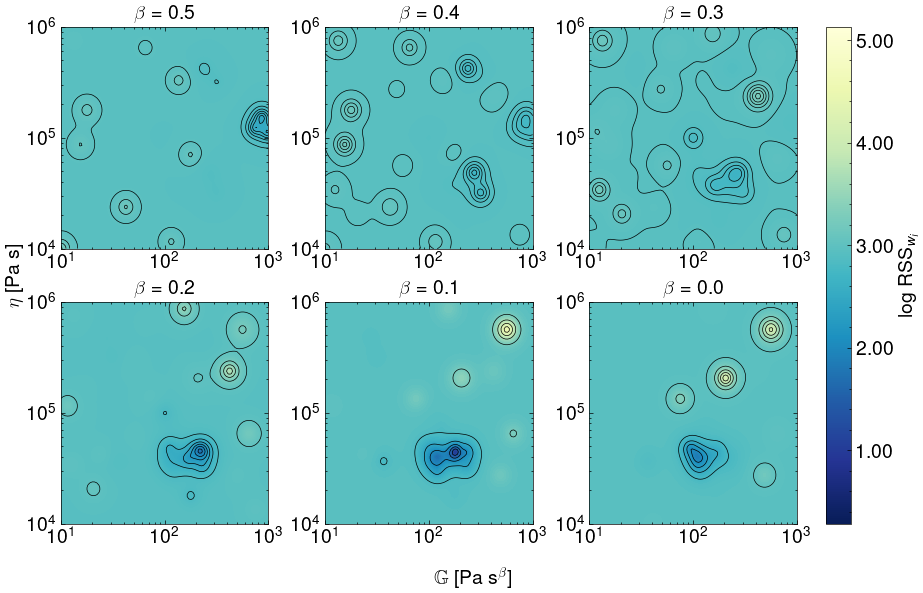

In [26]:
import matplotlib.colors as mcolors

def predict_model_on_grid_2D(model, param_space, beta_value, resolution=100):
    """
    Predict the model outputs on a 2D grid over logG and log_eta with a fixed beta value.
    """
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    beta_grid = torch.full_like(logG_grid, beta_value)  # Keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_1 = model.posterior(param_grid).mean.numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_1

# Define specific beta values to plot
beta_values = [0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
resolution = 100

# Ensure these values are correctly calculated
min_val, max_val = (-max(objective_values), -min(objective_values))

# Create subplots for each beta value
fig, axes = plt.subplots(2, 3, figsize=(9, 5.5), constrained_layout=True)
contours_list = []
global_minima = []  # To store global minima parameters

for ax, beta in zip(axes.flatten(), beta_values):
    logG_grid, logV_grid, preds_obj1 = predict_model_on_grid_2D(model, param_space, beta, resolution)
    
    # Convert logG and logV to G and V
    G = 10 ** logG_grid.numpy()
    V = 10 ** logV_grid.numpy()

    # Take negative predictions because of the sign inversion
    neg_preds_obj1 = -1 * scaler.inverse_transform(preds_obj1)
    
    # Find global minima
    min_index = np.unravel_index(neg_preds_obj1.argmin(), neg_preds_obj1.shape)
    global_min_logG = logG_grid[min_index]
    global_min_logV = logV_grid[min_index]
    global_min_G = 10 ** global_min_logG
    global_min_V = 10 ** global_min_logV
    global_min_value = neg_preds_obj1[min_index]
    global_minima.append((global_min_G.item(), global_min_V.item(), 10 ** global_min_value))
    
    # Create the 2D contour plot
    contour = ax.contourf(G, V, neg_preds_obj1, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
    contours_list.append(contour)
    ax.contour(G, V, neg_preds_obj1, levels=10, colors='black', linewidths=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(f'$\\beta$ = {beta}', fontsize=14)

# Create a ScalarMappable for the colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Add a single colorbar for all subplots
cbar = fig.colorbar(sm, ax=axes, location='right', aspect=20, pad=0.02, format='%.2f')
cbar.set_label('$\\log$ RSS$_{w_{i}}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Add common labels
fig.text(0.5, -0.05, '$\mathbb{G}$ [Pa s$^{\\beta}$]', ha='center', va='center', fontsize=14)
fig.text(-0.01, 0.5, '$\eta$ [Pa s]', ha='center', va='center', rotation='vertical', fontsize=14)

# Save the plot and show
plt.savefig("fig_obj1_relaxation_liquidfoam.pdf")
plt.show()

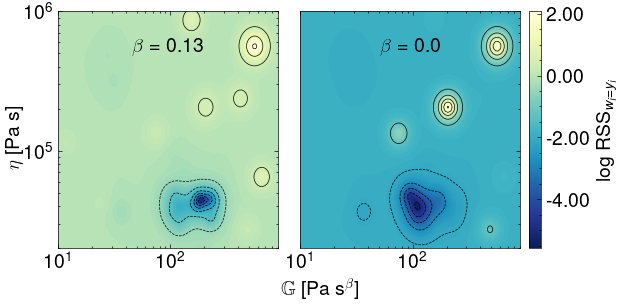

In [77]:
import matplotlib.colors as mcolors

def predict_model_on_grid_2D(model, param_space, beta_value, resolution=100):
    """
    Predict the model outputs on a 2D grid over logG and log_eta with a fixed beta value.
    """
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    beta_grid = torch.full_like(logG_grid, beta_value)  # Keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_1 = model.posterior(param_grid).mean.numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_1

# Define specific beta values to plot
beta_values = [0.13, 0.0]
resolution = 100

# Ensure these values are correctly calculated
min_val, max_val = (-np.max(preds_obj1), -np.min(preds_obj1))

# Collect all predictions for consistent color scaling
all_preds = []


# Create subplots for each beta value
fig, axes = plt.subplots(1, 2, figsize=(6, 2.75), constrained_layout=True)
contours_list = []
global_minima = []  # To store global minima parameters

# Loop over each beta value
for ax, beta in zip(axes.flatten(), beta_values):
    logG_grid, logV_grid, preds_obj1 = predict_model_on_grid_2D(model, param_space, beta, resolution)
    
    # Convert logG and logV to G and V
    G = 10 ** logG_grid.numpy()
    V = 10 ** logV_grid.numpy()

    # Invert predictions
    neg_preds_obj1 = -1 * preds_obj1  # Apply your scaler if needed
    all_preds.append(neg_preds_obj1)
    
    # Find global minima
    min_index = np.unravel_index(neg_preds_obj1.argmin(), neg_preds_obj1.shape)
    global_min_logG = logG_grid[min_index]
    global_min_logV = logV_grid[min_index]
    global_min_G = 10 ** global_min_logG
    global_min_V = 10 ** global_min_logV
    global_min_value = neg_preds_obj1[min_index]
    global_minima.append((global_min_G.item(), global_min_V.item(), 10 ** global_min_value))
    
    # 2D contour plot
    contour = ax.contourf(G, V, neg_preds_obj1, levels=100, cmap='YlGnBu_r')
    contours_list.append(contour)
    ax.contour(G, V, neg_preds_obj1, levels=10, colors='black', linewidths=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Set custom axis limits
    ax.set_xlim([10, 900])   # X-axis limits
    ax.set_ylim([20000, 1000000])  # Y-axis limits
    
    # Title inside each subplot
    ax.text(0.5, 0.85, f'$\\beta$ = {beta}', fontsize=14, ha='center', va='center', color='black', 
            transform=ax.transAxes)

    # Remove y-axis ticks for second and third subplots
    if ax != axes[0]:
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)

# Determine global min/max for consistent color scaling
all_preds_array = np.concatenate([p.flatten() for p in all_preds])
min_val, max_val = all_preds_array.min(), all_preds_array.max()

# Create a ScalarMappable for the colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Add a single colorbar for all subplots
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), location='right', aspect=20, pad=0.02, format='%.2f')
cbar.set_label('$\\log$ RSS$_{w_{i}=y_{i}}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Add common axis labels
fig.text(0.5, -0.05, '$\mathbb{G}$ [Pa s$^{\\beta}$]', ha='center', va='center', fontsize=14)
fig.text(-0.01, 0.5, '$\eta$ [Pa s]', ha='center', va='center', rotation='vertical', fontsize=14)

# Save and display
plt.savefig("fig_obj1_relaxation_liquidfoam_solution.pdf")
plt.show()

In [27]:
# Objective function to minimize (RRS weighted by true values)
def objective_minimize(params, time, y_true):
    logG, logV, beta = params
    G = 10 ** logG
    V = 10 ** logV
    params_no_scale = G, V, beta
    model = "FractionalMaxwellLiquid"
    evaluator = RelaxationEvaluator(model=model)
    
    # Compute oscillation data
    model_values = evaluator.compute_model(params_no_scale, time, mittag_leffler_type="Pade72")
    
    # Add noise
    error = createRandomError(time.shape[0], 0.02)
    model_values_noisy = np.multiply(model_values, error)
    
    # Define objective function: sum of squared relative errors for G' and G''
    obj1 = np.sum(((y_true - model_values_noisy) / y_true) ** 2)
    
    return obj1  # Return the raw error (we no longer need the -log10)

def callback(params):
    obj_value = objective_minimize(params, time, y_true)
    current_errors.append(obj_value)

In [28]:
import numpy as np
from scipy.optimize import minimize

custom_bounds = [(low, high) if i < 2 else (low, high) for i, (low, high) in enumerate(param_space)]


np.random.seed(42)
initial_guesses = np.random.uniform(param_space[:, 0], param_space[:, 1], (5, 3))
initial_guesses_list = initial_guesses.tolist()


# Define lists to store optimization results and errors
all_errors = []
results = []

# List of optimization methods to try
methods = ['Nelder-Mead']

start_time_NM = timer.time()


for method in methods:
    print(f"Running optimization with method: {method}")
    for initial_guess in initial_guesses_list:
        current_errors = []
        
        # Adjust options based on the method
        options = {'disp': True, 'maxiter': 1000}
        if method == 'Nelder-Mead':
            options.update({'xatol': 1e-9, 'fatol': 1e-9, 'maxfev': 2000})
        elif method in ['L-BFGS-B', 'TNC', 'SLSQP']:
            options.update({'ftol': 1e-9})

        # Bounds are only passed if the method supports them
        bounds = custom_bounds if method in ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell'] else None
        
        res = minimize(
            objective_minimize,
            initial_guess,
            args=(time, y_true),
            method=method,
            bounds=bounds,
            callback=callback if method != 'TNC' else None,  # TNC does not support callback
            options=options
        )
        
        results.append({'method': method, 'result': res})
        all_errors.append({'method': method, 'errors': current_errors})

final_time_NM = timer.time() - start_time_NM 

# Printing the cumulative time
print(f"Final time for all iterations: {final_time_NM:.4f} seconds")

# Extracting function values and optimized parameters
function_values = [res['result'].fun for res in results]
optimized_parameters = [res['result'].x for res in results]

Running optimization with method: Nelder-Mead


/tmp/ipykernel_19193/1822520037.py:37: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(


Final time for all iterations: 2.5137 seconds


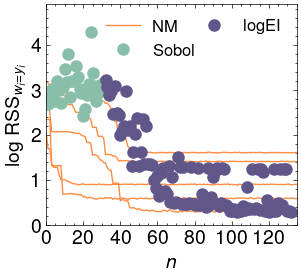

In [81]:
# Filter errors by method
nm_errors = [err['errors'] for err in all_errors if err['method'] == 'Nelder-Mead']
#powell_errors = [err['errors'] for err in all_errors if err['method'] == 'Powell']
#lbfgsb_errors = [err['errors'] for err in all_errors if err['method'] == 'L-BFGS-B']

# Configure the Figure
plt.figure(figsize=(3, 2.75), constrained_layout=True)

# Plot errors for Nelder-Mead runs
for i, error_list in enumerate(nm_errors):
    plt.plot(
        np.log10(error_list), 
        '-', 
        markersize=4,
        color='#FF8C42',               # Orange for Nelder-Mead
        label='NM' if i == 0 else ""  # Label only the first run
    )

# Plot errors for L-BFGS-B runs
#for i, error_list in enumerate(lbfgsb_errors):
#    plt.plot(
#        np.log10(error_list), 
#        '-',                         # Dashed line for L-BFGS-B
#        markersize=4,
#        color='#1F77B4',              # Blue for L-BFGS-B
#        label='L-BFGS-B' if i == 0 else ""     # Label only the first run
#    )

# Plot Initial Sobol Samples
plt.plot(
    iterations[:n_initial_points], 
    neg_objective_values[:n_initial_points], 
    'o', 
    markersize=8, 
    label='Sobol', 
    color='#89BFA9'
)

# Plot EI Samples
plt.plot(
    iterations[n_initial_points:], 
    neg_objective_values[n_initial_points:], 
    'o', 
    markersize=8, 
    label='logEI', 
    color='#60568A'
)


# Customize Plot Appearance
plt.xlim(0, 135)                                          # Set x-axis limit
plt.ylim(-0, 4.9)                                        # Uncomment and set y-axis limit if needed
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$\\log$ RSS$_{w_{i}=y_{i}}$', fontsize=14)           # Y-axis label
plt.xticks(fontsize=14)                                   # X-axis tick label size
plt.yticks(fontsize=14)                                   # Y-axis tick label size
plt.legend(fontsize=12, loc="upper right", ncols=2, columnspacing=0.1, 
           #bbox_to_anchor=(1.05, 1)
          )                       # Display legend

# Display the Plot
plt.savefig("fig_ei_relaxation_liquidfoam_comparison.pdf")                    # Uncomment to save the plot
plt.show()

Best Nelder-Mead Parameters: [2.27113518 4.64547115 0.12957676]
Best Nelder-Mead Function Value: 1.8270788622846506


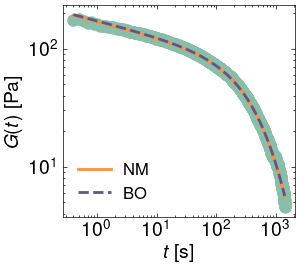

In [82]:
# Find the best results for Nelder-Mead and L-BFGS-B
nm_results = [res['result'] for res in results if res['method'] == 'Nelder-Mead']
#lbfgsb_results = [res['result'] for res in results if res['method'] == 'L-BFGS-B']

# Identify the best (lowest function value) result for each method
best_nm_result = min(nm_results, key=lambda r: r.fun)
#best_lbfgsb_result = min(lbfgsb_results, key=lambda r: r.fun)

# Extract optimized parameters and function values
best_nm_params = best_nm_result.x
#best_lbfgsb_params = best_lbfgsb_result.x

best_nm_value = best_nm_result.fun
#best_lbfgsb_value = best_lbfgsb_result.fun

# Print best results
print("Best Nelder-Mead Parameters:", best_nm_params)
print("Best Nelder-Mead Function Value:", best_nm_value)

#print("Best L-BFGS-B Parameters:", best_lbfgsb_params)
#print("Best L-BFGS-B Function Value:", best_lbfgsb_value)

# Compute model outputs for both best parameter sets
nm_model_values = evaluator.compute_model(
    (10**best_nm_params[0], 10**best_nm_params[1], best_nm_params[2]), time
)
#lbfgsb_model_values = evaluator.compute_model(
#    (best_lbfgsb_params[0], best_lbfgsb_params[1], best_lbfgsb_params[2]), time
#)

# Plot the data
plt.figure(figsize=(3, 2.75))

# Experimental data
plt.plot(time, y_true, 'o', markersize=8, color='#89BFA9')

# Nelder-Mead solution
plt.plot(time, nm_model_values, '-', color='#FF8C42', lw=2, label='NM')

# L-BFGS-B solution
#plt.plot(time, lbfgsb_model_values, '-', color='#1F77B4', lw=2, label='L-BFGS-B')

# BO solution
plt.plot(time, bo_model_values, '--', color='#60568A', lw=2, label='BO')   # BO model fit


# Configure the plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t$ [s]', fontsize=14)
plt.ylabel(r'$G(t)$ [Pa]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12, loc="lower left")

# Display the plot
plt.savefig("fig_bo_fit_relaxation_data_liquidfoam_comparison.pdf")  # Uncomment to save the plot
plt.show()